In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1013299245152836091
xla_global_id: -1
]


In [2]:
data_dir = os.path.join("/kaggle", 'input', 'praktikum-ai-modul-6-2024', 'train')

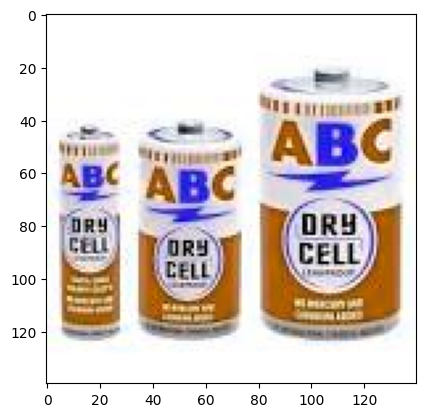

In [3]:
img = cv2.imread(os.path.join(data_dir, 'baterai', 'baterai_10.jpg'))
plt.imshow(img)

## 1. PreProcess and Data Load

### 1.1 Load Data

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 7063 files belonging to 18 classes.


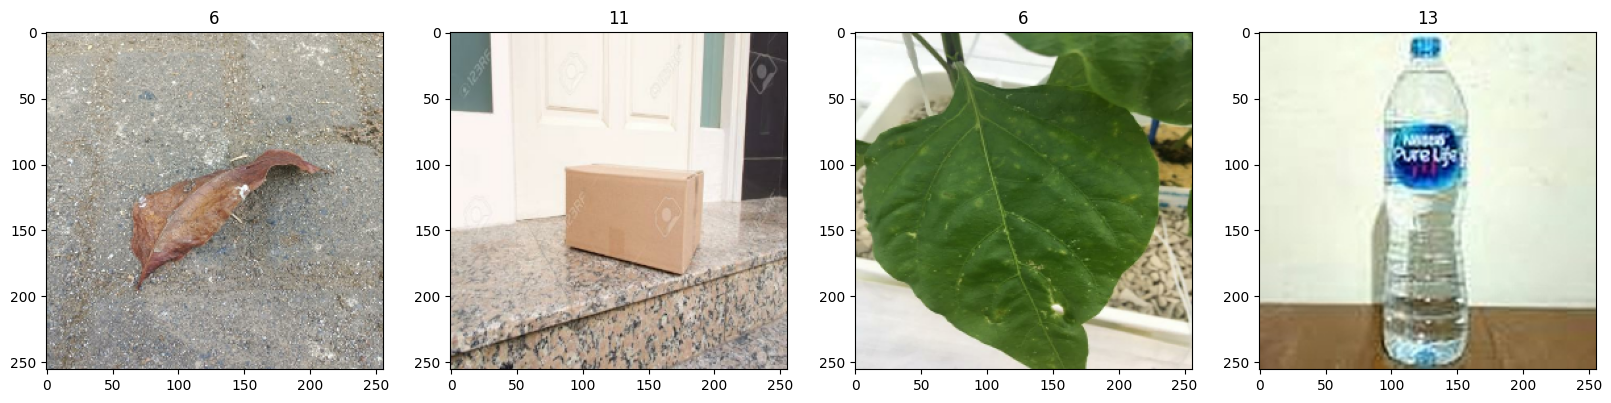

In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### 1.2 Augmented Data

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),  # Randomly zoom images up to 10%
    layers.RandomContrast(0.2),  # Randomly change the contrast of images
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images up to 10% in height and width
])

# Normalize the data
data = data.map(lambda x, y: (x / 255, y))

# # Apply data augmentation
data = data.map(lambda x, y: (data_augmentation(x, training=True), y))

### 1.3 Scale Data

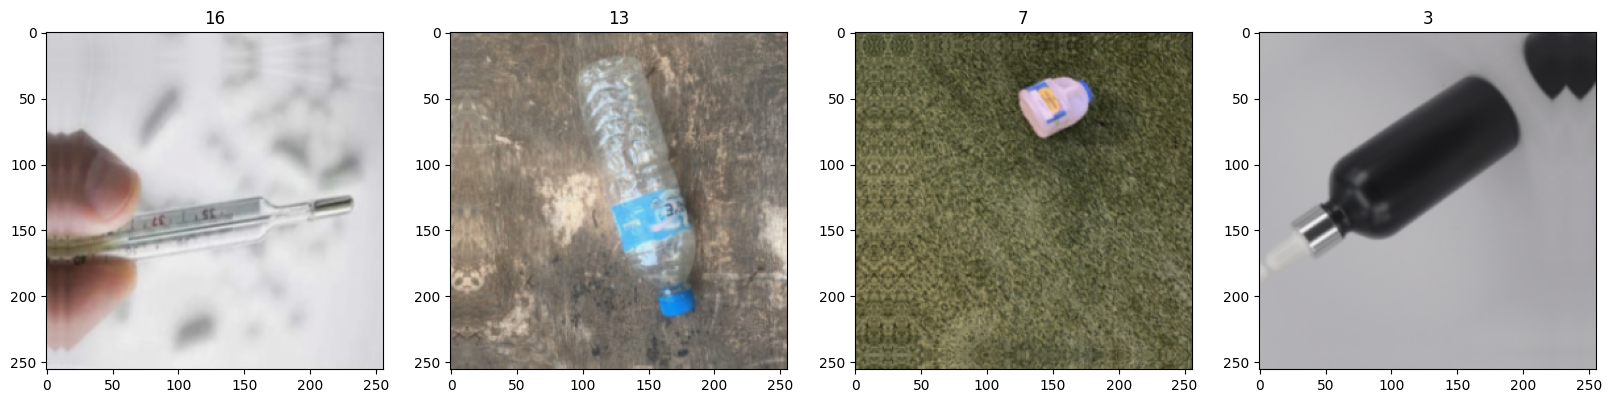

In [7]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

### 1.4 Split Data

In [8]:
len(data)

221

In [9]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [10]:
train_size

155

In [11]:
val_size

44

In [12]:
test_size

22

In [13]:
train_size+val_size+test_size

221

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 2. Build and Train (From Scracth)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout

model = Sequential()
classification = 18

### 2.1 Build Model

In [16]:
from tensorflow.keras import regularizers

# Define the L1 or L2 regularizer
# Note: You can adjust the value of l1 or l2 based on your preference
reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)

model.add(Conv2D(100, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(200, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(100, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(200, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(100, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=reg))
model.add(Dropout(rate=0.5))
model.add(Dense(classification, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 200)  │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 200)    │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       921,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,649,882 (6.29 MB)

 Trainable params: 1,649,882 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train Model

In [18]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

filepath="/kaggle/working/weights-improvement-{epoch:02d}-{accuracy:.2f}-{loss:.2f}-{val_accuracy:.2f}-{val_loss:.2f}.keras" #File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
logdir='logs'
valLoss_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
accr_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# custom_callback = CustomAccuracyThreshold(threshold=0.97)
callbacks = [tensorboard_callback, valLoss_stop, accr_stop, checkpoint]

with tf.device('/GPU:0'):
    hist = model.fit(train, epochs=25, validation_data=val)

Epoch 1/25
  1/155 ━━━━━━━━━━━━━━━━━━━━ 1:00:48 24s/step - accuracy: 0.0312 - loss: 3.3644

I0000 00:00:1718113808.936742      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718113808.959416      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.0629 - loss: 3.2248

W0000 00:00:1718114035.864939      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.0629 - loss: 3.2242 - val_accuracy: 0.0795 - val_loss: 2.9695
Epoch 2/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.1003 - loss: 2.9526 - val_accuracy: 0.1619 - val_loss: 2.7439
Epoch 3/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.1312 - loss: 2.7894 - val_accuracy: 0.1960 - val_loss: 2.6481
Epoch 4/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.1789 - loss: 2.6506 - val_accuracy: 0.2188 - val_loss: 2.5070
Epoch 5/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.2159 - loss: 2.5305 - val_accuracy: 0.2876 - val_loss: 2.3190
Epoch 6/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.2320 - loss: 2.4032 - val_accuracy: 0.3203 - val_loss: 2.2148
Epoch 7/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.2722 - loss: 2.3223 - val_accuracy: 0.3161 - val_loss: 2.1257
Epoch 8/25
155/155 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.2963 - loss: 2.2704 - val_accuracy: 0.357

## 3. Model Evaluation (From Scratch)

### 3.1 Plot Performance

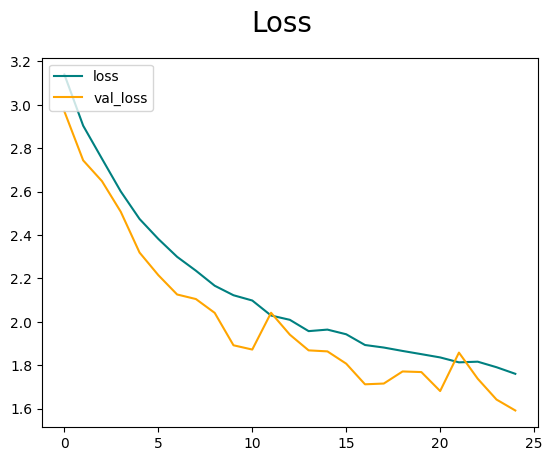

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 3.2 Validation

In [21]:
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.SparseCategoricalAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    
    # Convert predictions to class indices
    yhat = tf.argmax(yhat, axis=1)
    
    # Update metrics
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


W0000 00:00:1718120385.283444      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [22]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9724919199943542, Recall:0.9203675389289856, Accuracy:0.03741007298231125


### 3.3 Testing

In [2]:
test_dir = os.path.join("/kaggle", 'working')#/kaggle/working/
os.listdir(test_dir)

['.virtual_documents']